# Семинар 9. Введение в NLP: word2vec, RNN, LSTM, Seq2Seq, Attention 🤗

**NLP** (Natural Language Processing) - обработка естественного языка, общее направление искусственного интеллекта и математической лингвистики. Оно изучает проблемы компьютерного анализа и синтеза естественных языков

*Почему вообще это сложно?*
- "Он видел их семью своими глазами"
- "Эти типы стали есть в цехе"

![](images/1.png)

Примеры задач:
- Машинный перевод
- Sentiment analysis (выявление эмоциональной окраски)
- Проверка правописания
- Автодополнение текста
- Фильтр спама
- Голосовые помощники

## Word2vec

В каком виде можно представить слово для входа в нейросеть?

1. **One-hot representation**, длина вектора равна размеру словаря: $car = [0\ 0\ ...\ 1\ 0\ 0\ 0]$
   
  - Непрактично, т.к. размер словаря большой
  - Не получится близким семантически (по смыслу) словам сопоставить близкие векторы
2. **Distributed representation**, вектор из чисел с плавающей точкой: $car = [1.35\ 7.49\ ...\ -2.88\ 5.1\ 0.1\ -8.3]$.

Хотим научиться получать distributed representation слов

Обучим нейросеть, которая будет предсказывать, какие слова часто встречаются в контексе вместе с выбранным словом. Предположим, у нас есть скользящее окно фиксированного размера. Модель Skip-Gram тренируется предсказывать вероятность слов быть в одном контексте (внутри скользящего окна) по отношению к главному слову.

Датасет для skip-gram:
![](images/2.png)

Модель skip-gram. Между матрицами $W$ и $W^\prime$ нет активаций. В качестве функции потерь используется обычная кросс-энтропия. Для $x$, соответсвующего $fox$, в датасете будут пары $(fox, quick)$, $(fox, brown)$ и т.д.

![](images/3.png)

$Embedding(fox) = W(fox) + W^\prime(fox)$

Плюсы:
- Unsupervised
- Требует меньше памяти для матриц $W$ и $W^\prime$, т.к. $hidden\ size ≈ 300$

Минусы:
- Долго обучать

**Итог: научились делать эмбеддинги в distributed representation**

[Лекция по word2vec от sim0nsays](https://www.youtube.com/watch?v=MBQdMQUZMQM&list=PL5FkQ0AF9O_o2Eb5Qn8pwCDg7TniyV1Wb&index=9)

[Пост на эту же тему](https://lilianweng.github.io/posts/2017-10-15-word-embedding/)

Свойства word2vec: emb(Russia) - emb(Moscow) + emb(Paris) = emb(France)

А что делать, если слова нет в нашем наборе предложений, на котором обучили нейросеть? Как тогда делать эмбеддинг?

Эмбеддинги можно делать не только для отдельных слов, но и частей (например, морфем или слогов). Такое разделение называют [токенизацией](https://huggingface.co/docs/transformers/tokenizer_summary). Пример:

Вот так может выглядеть исходное предложение:

```text
Don't you love 🤗 Transformers? We sure do.
```

А вот так результат токенизации:
```text
["Do", "n't", "you", "love", "🤗", "Transformers", "?", "We", "sure", "do", "."]
```

На практике для задач NLP используют [Huggingface](https://github.com/huggingface/transformers) 🤗

[Видео о Huggingface](https://www.youtube.com/watch?v=QEaBAZQCtwE)

## RNN

Зачем нужны RNN?

- Обычные свёрточные сети принимают на вход вектор фиксированного размера и выдают вектор фиксированного размера
- Кроме того, обычные свёрточные сети отображают входной вектор в выходной при помощи фиксированного числа шагов

Реккуретные сети позволяют работать с последовательностями:

![](images/4.jpeg)

Слева направо:
1. One to one (например, классификация)
2. One to many (например, image captioning, т.е. описание изображения)
3. Many to one (например, sentiment analysis, т.е. анализ эмоциональной окраски)
4. Many to many (например, machine translation)
5. Synced many to many (например, классификация видео)

### Vanilla RNN

На выход `RNN` влияет не только входной вектор, но и все предыдущие векторы, которые были скормлены `RNN` в прошлом:

```python
rnn = RNN()
y = rnn.step(x) # x is an input vector, y is the RNN's output vector
```

Параметры `RNN`: `W_hy, W_hh, W_xh`.

```python
class RNN:
  # ...
  def step(self, x):
    # update the hidden state
    self.h = np.tanh(np.dot(self.W_hh, self.h) + np.dot(self.W_xh, x))
    # compute the output vector
    y = np.dot(self.W_hy, self.h)
    return y
```

Тоже можно делать несколько слоёв:

```python
y1 = rnn1.step(x)
y = rnn2.step(y1)
```

![](images/5.jpeg)

*Пример: генерация текста*

### Пример с vanilla RNN для генерации текста на numpy ([оргинал кода](https://github.com/JY-Yoon/RNN-Implementation-using-NumPy/blob/master/RNN%20Implementation%20using%20NumPy.ipynb)):

In [ ]:
import numpy as np

In [ ]:
# load text data

txt_data = "abcdefghijklmnopqrstuvwxyz abcdefghijklmnopqrstuvwxyz abcdefghijklmnopqrstuvwxyz " # input data
# txt_data = open('input.txt', 'r').read() # test external files

chars = list(set(txt_data)) # split and remove duplicate characters. convert to list.

num_chars = len(chars) # the number of unique characters
txt_data_size = len(txt_data)

print("unique characters : ", num_chars) # You can see the number of unique characters in your input data.
print("txt_data_size : ", txt_data_size)

unique characters :  27
txt_data_size :  81


In [ ]:
# one hot encode
char_to_int = dict((c, i) for i, c in enumerate(chars)) # "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(chars))
print(char_to_int)
print("----------------------------------------------------")
print(int_to_char)
print("----------------------------------------------------")
# integer encode input data
integer_encoded = [char_to_int[i] for i in txt_data] # "integer_encoded" is a list which has a sequence converted from an original data to integers.
print(integer_encoded)
print("----------------------------------------------------")
print("data length : ", len(integer_encoded))

{'l': 0, 'g': 1, 'j': 2, 'm': 3, ' ': 4, 'u': 5, 'y': 6, 'd': 7, 'p': 8, 'f': 9, 'k': 10, 's': 11, 'q': 12, 'a': 13, 'v': 14, 'w': 15, 'x': 16, 't': 17, 'z': 18, 'n': 19, 'h': 20, 'c': 21, 'e': 22, 'i': 23, 'b': 24, 'o': 25, 'r': 26}
----------------------------------------------------
{0: 'l', 1: 'g', 2: 'j', 3: 'm', 4: ' ', 5: 'u', 6: 'y', 7: 'd', 8: 'p', 9: 'f', 10: 'k', 11: 's', 12: 'q', 13: 'a', 14: 'v', 15: 'w', 16: 'x', 17: 't', 18: 'z', 19: 'n', 20: 'h', 21: 'c', 22: 'e', 23: 'i', 24: 'b', 25: 'o', 26: 'r'}
----------------------------------------------------
[13, 24, 21, 7, 22, 9, 1, 20, 23, 2, 10, 0, 3, 19, 25, 8, 12, 26, 11, 17, 5, 14, 15, 16, 6, 18, 4, 13, 24, 21, 7, 22, 9, 1, 20, 23, 2, 10, 0, 3, 19, 25, 8, 12, 26, 11, 17, 5, 14, 15, 16, 6, 18, 4, 13, 24, 21, 7, 22, 9, 1, 20, 23, 2, 10, 0, 3, 19, 25, 8, 12, 26, 11, 17, 5, 14, 15, 16, 6, 18, 4]
----------------------------------------------------
data length :  81


In [ ]:
# hyperparameters

iteration = 5000
sequence_length = 10
batch_size = round((txt_data_size /sequence_length)+0.5) # = math.ceil
hidden_size = 100  # size of hidden layer of neurons.  
learning_rate = 1e-1


# model parameters

W_xh = np.random.randn(hidden_size, num_chars)*0.01     # weight input -> hidden. 
W_hh = np.random.randn(hidden_size, hidden_size)*0.01   # weight hidden -> hidden
W_hy = np.random.randn(num_chars, hidden_size)*0.01     # weight hidden -> output

b_h = np.zeros((hidden_size, 1)) # hidden bias
b_y = np.zeros((num_chars, 1)) # output bias

h_prev = np.zeros((hidden_size,1)) # h_(t-1)

In [ ]:
def forwardprop(inputs, targets, h_prev):
        
    # Since the RNN receives the sequence, the weights are not updated during one sequence.
    xs, hs, ys, ps = {}, {}, {}, {} # dictionary
    hs[-1] = np.copy(h_prev) # Copy previous hidden state vector to -1 key value.
    loss = 0 # loss initialization
    
    for t in range(len(inputs)): # t is a "time step" and is used as a key(dic).  
        
        xs[t] = np.zeros((num_chars,1)) 
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(W_xh, xs[t]) + np.dot(W_hh, hs[t-1]) + b_h) # hidden state. 
        ys[t] = np.dot(W_hy, hs[t]) + b_y # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars. 
        # Softmax. -> The sum of probabilities is 1 even without the exp() function, but all of the elements are positive through the exp() function.
 
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss). Efficient and simple code

#         y_class = np.zeros((num_chars, 1)) 
#         y_class[targets[t]] =1
#         loss += np.sum(y_class*(-np.log(ps[t]))) # softmax (cross-entropy loss)        

    return loss, ps, hs, xs 

In [ ]:
def backprop(ps, inputs, hs, xs):

    dWxh, dWhh, dWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy) # make all zero matrices.
    dbh, dby = np.zeros_like(b_h), np.zeros_like(b_y)
    dhnext = np.zeros_like(hs[0]) # (hidden_size,1) 

    # reversed
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t]) # shape (num_chars,1).  "dy" means "dloss/dy"
        dy[targets[t]] -= 1 # backprop into y. After taking the soft max in the input vector, subtract 1 from the value of the element corresponding to the correct label.
        dWhy += np.dot(dy, hs[t].T)
        dby += dy 
        dh = np.dot(W_hy.T, dy) + dhnext # backprop into h. 
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity #tanh'(x) = 1-tanh^2(x)
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(W_hh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]: 
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients.  
    
    return dWxh, dWhh, dWhy, dbh, dby

In [ ]:
data_pointer = 0

# memory variables for Adagrad
mWxh, mWhh, mWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy)
mbh, mby = np.zeros_like(b_h), np.zeros_like(b_y) 


for i in range(iteration):
    h_prev = np.zeros((hidden_size,1)) # reset RNN memory
    data_pointer = 0 # go from start of data
    
    for b in range(batch_size):
        
        inputs = [char_to_int[ch] for ch in txt_data[data_pointer:data_pointer+sequence_length]]
        targets = [char_to_int[ch] for ch in txt_data[data_pointer+1:data_pointer+sequence_length+1]] # t+1        
            
        if (data_pointer+sequence_length+1 >= len(txt_data) and b == batch_size-1): # processing of the last part of the input data. 
#             targets.append(char_to_int[txt_data[0]])   # When the data doesn't fit, add the first char to the back.
            targets.append(char_to_int[" "])   # When the data doesn't fit, add space(" ") to the back.


        # forward
        loss, ps, hs, xs = forwardprop(inputs, targets, h_prev)
#         print(loss)
    
        # backward
        dWxh, dWhh, dWhy, dbh, dby = backprop(ps, inputs, hs, xs) 
        
        
    # perform parameter update with Adagrad
        for param, dparam, mem in zip([W_xh, W_hh, W_hy, b_h, b_y], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam # elementwise
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update      
    
        data_pointer += sequence_length # move data pointer
        
    if i % 100 == 0:
        print ('iter %d, loss: %f' % (i, loss)) # print progress

iter 0, loss: 3.504354
iter 100, loss: 0.015185
iter 200, loss: 0.007141
iter 300, loss: 0.004599
iter 400, loss: 0.003362
iter 500, loss: 0.002635
iter 600, loss: 0.002160
iter 700, loss: 0.001827
iter 800, loss: 0.001581
iter 900, loss: 0.001392
iter 1000, loss: 0.001242
iter 1100, loss: 0.001121
iter 1200, loss: 0.001020
iter 1300, loss: 0.000936
iter 1400, loss: 0.000864
iter 1500, loss: 0.000802
iter 1600, loss: 0.000748
iter 1700, loss: 0.000701
iter 1800, loss: 0.000659
iter 1900, loss: 0.000622
iter 2000, loss: 0.000589
iter 2100, loss: 0.000559
iter 2200, loss: 0.000532
iter 2300, loss: 0.000507
iter 2400, loss: 0.000485
iter 2500, loss: 0.000464
iter 2600, loss: 0.000445
iter 2700, loss: 0.000427
iter 2800, loss: 0.000411
iter 2900, loss: 0.000396
iter 3000, loss: 0.000382
iter 3100, loss: 0.000369
iter 3200, loss: 0.000357
iter 3300, loss: 0.000345
iter 3400, loss: 0.000334
iter 3500, loss: 0.000324
iter 3600, loss: 0.000315
iter 3700, loss: 0.000306
iter 3800, loss: 0.00029

In [ ]:
def predict(test_char, length):
    x = np.zeros((num_chars, 1)) 
    x[char_to_int[test_char]] = 1
    ixes = []
    h = np.zeros((hidden_size,1))

    for t in range(length):
        h = np.tanh(np.dot(W_xh, x) + np.dot(W_hh, h) + b_h) 
        y = np.dot(W_hy, h) + b_y
        p = np.exp(y) / np.sum(np.exp(y)) 
        ix = np.random.choice(range(num_chars), p=p.ravel()) # ravel -> rank0
        # "ix" is a list of indexes selected according to the soft max probability.
        x = np.zeros((num_chars, 1)) # init
        x[ix] = 1 
        ixes.append(ix) # list
    txt = ''.join(int_to_char[i] for i in ixes)
    print('----\n %s \n----' % (txt, ))

In [ ]:
predict('a',30) # (char, len of output)

----
 bcdefghijklmnpqnoprstuvwxyz ab 
----


In [ ]:
predict('b',30)

----
 cdefghijgqijklmnpqrstuvwxyz lm 
----


Пример: генерация текста в стиле Шекспра при помощи `RNN` ([пост](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) Andrej Karpathy)

```text
PANDARUS:
Alas, I think he shall be come approached and the day
When little srain would be attain'd into being never fed,
And who is but a chain and subjects of his death,
I should not sleep.

Second Senator:
They are away this miseries, produced upon my soul,
Breaking and strongly should be buried, when I perish
The earth and thoughts of many states.

DUKE VINCENTIO:
Well, your wit is in the care of side and that.

Second Lord:
They would be ruled after this chamber, and
my fair nues begun out of the fact, to be conveyed,
Whose noble souls I'll have the heart of the wars.

Clown:
Come, sir, I will make did behold your worship.

VIOLA:
I'll drink it.
```

Посмотрим, как это работает.

Тест, генерируемый `LSTM`, обученной на "Войне и мире":

- 100 итераций: пока что не похоже на текст

  ```text
tyntd-iafhatawiaoihrdemot  lytdws  e ,tfti, astai f ogoh eoase rrranbyne 'nhthnee e 
plia tklrgd t o idoe ns,smtt   h ne etie h,hregtrs nigtike,aoaenns lng
```

- 300 итераций: вырисовываются слова, пробелы, знаки препинания

  ```text
"Tmont thithey" fomesscerliund
Keushey. Thom here
sheulke, anmerenith ol sivh I lalterthend Bleipile shuwy fil on aseterlome
coaniogennc Phe lism thond hon at. MeiDimorotion in ther thize."
```

- 500 итераций: выучила простые местоимения ("he", "we", etc.)

  ```text
we counter. He stutn co des. His stanted out one ofler that concossions and was 
to gearang reay Jotrets and with fre colt otf paitt thin wall. Which das stimn 
```

- 700 итераций: похоже на английский язык

  ```text
  Aftair fall unsuch that the hall for Prince Velzonski's that me of
her hearly, and behs to so arwage fiving were to it beloge, pavu say falling misfort 
how, and Gogition is so overelical and ofter.
```

- 1200 итераций: знаки препинания

  ```text
  "Kite vouch!" he repeated by her
door. "But I would be done and quarts, feeling, then, son is people...."
```

- 2000 итераций:

  ```text
  "Why do what that day," replied Natasha, and wishing to himself the fact the
princess, Princess Mary was easier, fed in had oftened him.
Pierre aking his soul came to the packs and drove up his father-in-law women.
```

## LSTM - Long Short Term Memory Networks

`RNN` можно представить в следующем виде:

![](images/6.png)

В реальной жизни мы можем наткнуться на текст, в котором начало мысли и её логическое окончание сильно разделены между собой. Например, самое длинное предложение из романа "Сто лет одиночества" выглядит так:

```text
Это Фернанда бродила по всему дому, жалуясь, что воспитали её как королеву, а она превратилась в служанку в этом сумасшедшем доме, мыкается с мужем — бездельником, безбожником и бабником, который валится на кровать, разевает пасть и ждет, что ему туда посыплется манна небесная, пока она гнет спину и тащит на себе этот дом, который держится на честном слове, дом, где она все чистит, убирает, чинит с рассвета до поздней ночи, и, как спать ложится, у неё глаза жжет, словно в них песку насыпали, и никто никогда не скажет ей: добрый день, Фернанда, хорошо ли тебе спалось, Фернанда, никто не спросит её, хотя бы из вежливости, почему она так бледна, почему она просыпается с такими синяками под глазами, хотя, конечно, она и не ждет никакого внимания от этой семьи, в конце концов они всегда относились к ней как к помехе, как к тряпке, которой снимают с плиты горячие котелки, как к уродцу, намалеванному на стене, эта семейка всегда интриговала против неё по углам, называла её ханжой, называла её фарисейкой, называла её притворой, и Амаранта — упокой, Господи, её душу — даже во всеуслышание объявила, что она, Фернанда, из тех, кто путает задний проход с великим постом, — Боже милостивый, что за выражение, — она сносила все покорно, подчиняясь воле Всевышнего, но терпению её пришел конец, когда этот негодяй, Хосе Аркадио Второй, сказал, что семья погибла, потому что впустила в дом качако в юбке, вообразите себе властолюбивого качако в юбке — прости, Господи, мое прегрешение, — качако сучьей породы, из тех качако, что правительство послало убивать рабочих, и подумать только — он имел в виду её, Фернанду, крестницу герцога Альбы, даму столь знатного происхождения, что супруги президентов ей завидовали, чистокровную дворянку, которая имеет право подписываться одиннадцатью испанскими именами, единственную смертную в этом городишке ублюдков, которую не может смутить стол на шестнадцать кувертов, а этот грязный прелюбодей, её муж, сказал, умирая со смеху, что столько ложек и вилок и столько ножей и чайных ложечек потребно не добрым христианам, а разве что сороконожкам, и ведь только она одна знает, когда следует подавать белое вино и с какой руки и в какой бокал наливать и когда следует подавать красное вино и с какой руки и в какой бокал наливать, не то что эта деревенщина — Амаранта — упокой, Господи, её душу, — которая считала, что белое вино пьют днем, а красное вечером, она, Фернанда, единственная на всем побережье, может похвастаться тем, что ходит только в золотой ночной горшок, а у этого злостного франкмасона полковника Аурелиано Буэндиа — упокой, Господи, его душу — хватило дерзости спросить, почему она заслужила эту привилегию, не потому ли, что испражняется хризантемами, представьте себе, так он и сказал, этими самыми словами, — а Рената, её собственная дочь, нагло подсмотрела, как она справляет большую нужду в спальне, и потом рассказывала, что горшок действительно весь золотой и со многими гербами, но внутри его простое дерьмо, самое обыкновенное дерьмо, и даже хуже, чем обыкновенное, — дерьмо качако, — представьте себе, её собственная, родная дочь; что правда, то правда, она никогда не обманывалась относительно других членов семейства, но, во всяком случае, имела право ожидать хоть малую толику уважения со стороны своего мужа, ибо, как ни говори, он её супруг перед Богом и людьми, её господин, её заступник, который возложил на себя по своей доброй воле и по воле Божьей великую ответственность и взял её из родительского дома, где она жила, не зная нужды и забот, где она плела похоронные венки только ради времяпрепровождения, ведь её крестный прислал ей письмо, скрепленное его собственноручной подписью и оттиском его перстня на сургучной печати, письмо, подтверждающее, что руки его крестницы сотворены не для трудов земных, а для игры на клавикордах, и, однако, этот бесчувственный чурбан, её муж, извлек её из родительского дома и, напутствуемый добрыми советами и предупреждениями, привез сюда, в адское пекло, где так жарко, что и дышать-то нечем, и не успела она соблюсти воздержание, предписанное в дни поста, а он уже схватил свои прелестные сундуки и свой паршивый аккордеон и отправился жить в беззаконии со своей наложницей, с этой жалкой потаскухой, достаточно взглянуть на её задницу — пусть так, слово уже вылетело, — достаточно взглянуть, как она вертит своей задницей, здоровенной, будто у молодой кобылы, и сразу станет ясно, что это за птица, что это за тварь, — совсем другой породы, чем она, Фернанда, которая остается дамой и во дворе, и в свинарнике, и за столом, и в постели, прирожденной дамой, богобоязненной, законопослушной, покорной своей судьбе, она, конечно, не согласится вытворять разные грязные штучки, их можно вытворять с той, другой, та, другая, разумеется, готова на все, как француженки, и даже хуже их в тысячу раз, француженки хоть поступают честно и вешают на двери красный фонарь, еще бы не хватало, чтобы он вытворял такое свинство с нею, с Фернандой, единственной и возлюбленной дочерью доньи Ренаты Арготе и дона Фернандо дель Карпио, в особенности последнего, этого святого человека, истинного христианина, кавалера ордена Святой гробницы, а они особой милостью Божьей избегают тления в могиле, кожа у них и после смерти остается чистой и гладкой, как атласное платье невесты, а глаза живыми и прозрачными, как изумруды.
```

Люди могут запомнить такое количество контекста (хотя нам сложно), а вот `RNN`, как показывает практика, не справляется с этим.

![](images/7.png)

Внутри этой цепочки `RNN` большое число умножений на одну и ту же матрицу → градиенты будут либо взрываться, либо затухать

![](images/8.png)

*Схема RNN*

![](images/9.png)

*Схема LSTM*

- Более хитро устроен один блок
- Есть не один вспомогательный вектор, а два (hidden $h$ и cell $c$). Идея в том, что c мы хотим менять как можно меньше
менять $c$, чтобы через него легко шёл градиент
- Есть три гейта: forget gate, input gate, output gate
  1. Хотим решить, какую информацию выбросить из *cell state*. Для этого мы используем т.н. **forget gate**. В нашем примере с моделью, которая пытается предсказать следующие слова по началу предложения, это может быть информация о роде существительного (поменялось существительное - нужно забыть его род) и т.п. Получаем вектор с числами от 0 до 1, который домножается на *cell state* $c_{t-1}$ (здесь и дальше $[,]$ обозначают конкатенацию)
  ![](images/10.png)
  2. Дальше нужно решить, какую информацию мы хотим сохранить внутри *cell state* $c_t$. **Input gate** позволяет определить, какие значения мы хотим обновить. Например, мы  встретили в тексте новое существительное и хотим добавить информацию о его роде:
  ![](images/11.png)
  3. Пересчитываем $c_t$:
  ![](images/12.png)
  4. Считаем, какой у нас будет вектор внутреннего состояния $h_t$. Например, так как мы только что видели предмет, а дальше, скорее всего, пойдет глагол, мы хотим передать состояние о том, единственное у нас или множественное число
  ![](images/13.png)
- `LSTM` бывает двунаправленной (bidirectional). Так же, как и `RNN`, слои `LSTM` можно стакать друг на друга

[Пост про LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[Ещё один пост про LSTM](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

### Пример с LSTM


Посмотрим на то, как работает LSTM на задаче Part-Of-Speech tagging для английского языка.

Будем работать с таким набором тегов:

    ADJ - adjective (new, good, high, ...)
    ADP - adposition (on, of, at, ...)
    ADV - adverb (really, already, still, ...)
    CONJ - conjunction (and, or, but, ...)
    DET - determiner, article (the, a, some, ...)
    NOUN - noun (year, home, costs, ...)
    NUM - numeral (twenty-four, fourth, 1991, ...)
    PRT - particle (at, on, out, ...)
    PRON - pronoun (he, their, her, ...)
    VERB - verb (is, say, told, ...)
    . - punctuation marks (. , ;)
    X - other (ersatz, esprit, dunno, ...)


In [ ]:
!pip install bokeh
!pip install gensim
!pip install nltk
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

In [ ]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


Пример размеченного предложения

In [ ]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


In [ ]:
train_data[0]

[('``', '.'),
 ('What', 'DET'),
 ('did', 'VERB'),
 ('you', 'PRON'),
 ('think', 'VERB'),
 ('about', 'ADP'),
 ("Bang-Jensen's", 'NOUN'),
 ('contention', 'NOUN'),
 ('of', 'ADP'),
 ('errors', 'NOUN'),
 ('and', 'CONJ'),
 ('omissions', 'NOUN'),
 ('in', 'ADP'),
 ('the', 'DET'),
 ('Hungarian', 'ADJ'),
 ('report', 'NOUN'),
 ("''", '.'),
 ('?', '.'),
 ('?', '.')]

Построим маппинги из слов в индекс и из тега в индекс:

In [ ]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'ADV', '.', 'ADJ', 'CONJ', 'DET', 'PRT', 'X', 'NUM', 'ADP', 'NOUN', 'PRON', 'VERB'}


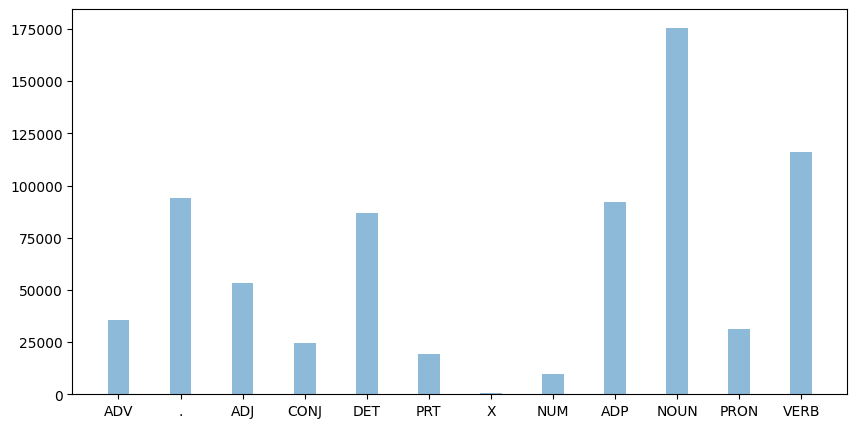

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()


Самый простой вариант, который мы можем придумать - это просто считать по нашему датасету, какова вероятность для конкретного слова быть заданной частью речи. Для большинства слов (артикли, предлоги и т.д.) такой подход работает. Но есть и сложные случаи:

```text
He saw a smile at her face. You smile at me.
```

Поэтому нам очень полезно учитывать контекст при предсказании тега.
Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо.

- Учим эмбеддинги слов сами (можно взять предобученные)
- `LSTM` делает предсказания для каждого слова
- Линейный слой с софтмаксом делает предсказания тегов

In [ ]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [ ]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [ ]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape


((32, 4), (32, 4))

In [ ]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.tagset_size = tagset_size
        self.lstm_layers_count = lstm_layers_count
        self.lstm_hidden_dim = lstm_hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count)
        self.fc = nn.Linear(lstm_hidden_dim, tagset_size)
    
    def forward(self, inputs):
        embedded_inputs = self.embedding(inputs)
        output, _ = self.lstm(embedded_inputs)
        output = self.fc(output)
        return output



In [ ]:
X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

In [ ]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

In [ ]:
logits = model(X_batch)

def compute_accuracy(pred, target):
    _, indices = torch.max(pred, -1)
    num_total = torch.sum(target>0).item()
    num_cor = torch.sum((indices == target)*(target>0)).item()
    return num_cor, num_total

compute_accuracy(logits, y_batch)

(5, 92)

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
loss(logits.reshape((-1,len(tag2ind))), y_batch.view(-1))

tensor(2.6305, grad_fn=<NllLossBackward0>)

In [ ]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch).cuda(), LongTensor(y_batch).cuda()
                
                logits = model(X_batch)
                loss = criterion(logits.reshape((-1, len(tag2ind))), y_batch.view(-1))
                epoch_loss += loss.item()
                
                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                cur_correct_count, cur_sum_count = compute_accuracy(logits, y_batch)

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [ ]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=10,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 10] Train: Loss = 0.67815, Accuracy = 78.60%: 100%|██████████| 572/572 [00:05<00:00, 100.31it/s]
[1 / 10]   Val: Loss = 0.35335, Accuracy = 88.20%: 100%|██████████| 13/13 [00:00<00:00, 74.23it/s]
[2 / 10] Train: Loss = 0.27439, Accuracy = 90.91%: 100%|██████████| 572/572 [00:04<00:00, 125.11it/s]
[2 / 10]   Val: Loss = 0.24027, Accuracy = 91.67%: 100%|██████████| 13/13 [00:00<00:00, 66.49it/s]
[3 / 10] Train: Loss = 0.18628, Accuracy = 93.88%: 100%|██████████| 572/572 [00:04<00:00, 123.79it/s]
[3 / 10]   Val: Loss = 0.19730, Accuracy = 93.15%: 100%|██████████| 13/13 [00:00<00:00, 72.69it/s]
[4 / 10] Train: Loss = 0.13947, Accuracy = 95.37%: 100%|██████████| 572/572 [00:04<00:00, 127.39it/s]
[4 / 10]   Val: Loss = 0.18057, Accuracy = 93.77%: 100%|██████████| 13/13 [00:00<00:00, 73.48it/s]
[5 / 10] Train: Loss = 0.10897, Accuracy = 96.36%: 100%|██████████| 572/572 [00:04<00:00, 122.86it/s]
[5 / 10]   Val: Loss = 0.17914, Accuracy = 93.97%: 100%|██████████| 13/13 [00:00<00:00, 62.48i

## Seq2Seq

Самой популярной задачей seq2seq является машинный перевод.
Пусть у нас есть вход - последовательность $x_1,x_2,...,x_m$ - и выход - последовательность $y_1,y_2,...,y_n$. Задачу перевода можно представить как поиск последовательности $y_i$, такой, что она является наиболее вероятной при заданной последовательности $x_i$:

$$y^* = \underset{y}{argmax}\ p(y|x) $$

Задача перевода:

![](images/14.gif)

Перевод с точки зрения человека (слева) и нейросети (справа):

![](images/15.png)

Состоит традиционно из энкодера и декодера
- Энкодер считывает входную последовательность и получает на выходе вектор
- Декодер декодирует этот вектор в последовательность
- Можем в качестве энкодера и декодера выбрать не просто vanilla RNN, но и, например, LSTM
- У RNN или LSTM может быть несколько слоёв

![](images/16.png)

In [1]:
from IPython.display import HTML

In [14]:
HTML("""
<video width="560" height="315" controls>
  <source src="images/vid1.mp4" type="video/mp4">
</video>
""")

In [17]:
HTML("""
<video width="560" height="315" controls>
  <source src="images/vid2.mp4" type="video/mp4">
</video>
""")

![](images/17.png)

*Сеть для задачи machine translation, encoder и decoder состоят из RNN*

*Note: на этот и следующие рисунки нужно смотреть слева направо. Можно представить себе воображаемую ось x, соответствующую течению времени (time steps)*

### Обучение

![](images/18.png)

*Сеть для задачи machine translation, энкодер и декодер состоят из нескольких слоев RNN*

Задача обучения - максимизировать параметры, которые позволяют получить последовательность $y_i$ при заданных $x_i$. Используем обычную кросс-энтропию:

$$𝑳(p, p^*) = -log(p_{y_t}) = -log(p(y_t|y_{<t}, x)$$



In [19]:
HTML("""
<video width="560" height="315" controls>
  <source src="images/vid4.mp4" type="video/mp4">
</video>
""")

### Inference

- Greedy Decoding: на каждом шаге выбирать наиболее вероятный токен
- Beam Search: следить за несколькими наиболее вероятными гипотезами

In [18]:
HTML("""
<video width="560" height="315" controls>
  <source src="images/vid3.mp4" type="video/mp4">
</video>
""")

## Attention

У нашей сети, состоящей из энкодера, который выдаёт один вектор, и декодера, есть "узкое место" - вектор, который получается на выходе декодера:

- Энкодеру сложно информацию обо всём предложении уместить в один вектор
- Для декодера на каждом time step скорее важна конкретная часть предложения, а не весь вектор

Для того, чтобы бороться с этой проблемой, придумали механизм внимания, или attention (появился в статье [*Bahdanau et al*](https://arxiv.org/pdf/1409.0473.pdf))

![](images/19.png)

Теперь у декодера появился доступ ко всем выходам $s_i$ энкодера, а не только к последнему $s_m$

На рисунке ниже: на шаге (4) декодера нам надо предсказать слово "cat". Наш механизм внимания должен понять, что вектор (3) из исходной последовательности $s_3$, который соответствует слову "котя", наиболее важен для декодера.

На каждом шаге декодера механизм внимания:

1. Получает свои входы. Это состояние декодера $h_t$ и все состояния энкодера $s_1,...,s_m$
2. Считает attention scores для пар $s_i, h_t$, т.е. $score(h_t, s_i)$
3. Считает attention weights - просто применяет софтмакс к attention scores
4. Считает выход - просто состояния энкодера $s_i$, перевзвешенные с коэффициентами, равными attention weights

![](images/20.png)

![](images/21.png)

Как посчитать функцию внимания от двух векторов одинакового размера? Есть несколько популярных способов:

1. Скалярное произведение
2. Билинейная фукция (Luong attention, ~ как скалярное произведение, только посередине матрица)
3. Multi-layer perceptron (Bahdanau attention) - метод, предложенный в оригинальной статье

![](images/22.png)

### Seq2seq + Attention

Есть разные подходы к тому, как добавлять attention в задачу seq2seq.
Но всегда идея одна и та же: декодер теперь знает не только о финальном выходе энкодера, но и обо всех его промежуточных состояниях. Чтобы выбрать, какое именно состояние энкодера более важно, на каждом time step декодера используется attention function. С помощью неё рассчитываются коэффициенты во взвешенной сумме и получается контекстный вектор $c_0$. 




![](images/23.png)

*Bandahau model*

![](images/24.png)

*Luong model*

[Видео про seq2seq+attention](https://www.youtube.com/watch?v=B3uws4cLcFw)
